In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import seaborn as sns
import os

In [146]:
# setting directories
## change this to the directory where you have stored the data for the project
base_dir = "C:\\Users\\khash\\OneDrive\\Documents\\GitHub\\WM_chunking"
behav_dir = os.path.join(base_dir, "data", "behavioural", "raw")

# setting some default variables
return_subjs = ["s10", "s11", "s12", "s14", "s15", "s16", "s17", "s18", "s19", "s20", "s21", "s22", "s23", "s24", "s25"]

In [147]:
def clean_df(subject):
    """
    Takes in the subject name and does initial cleaning (removes unwanted columns)
    Args:
        subject (str) - name assigned to the subject 
    """
    
    # get subject directory
    subj_dir = os.path.join(behav_dir, subject)
    # load the dataframe
    df_sub = pd.read_csv(os.path.join(subj_dir, f'WMC_{subject}.csv'), converters={'response_time': pd.eval})
    
    # deleting the Unnamed columns
    ## get all the columns with Unnamed 
    filter_col = [col for col in df_sub if col.startswith('Unnamed')]
    ## drop all the unnamed columns
    df_sub = df_sub.drop(filter_col, axis = 1)
    
    # loop over runs and add a column representing the trial number
    runs = np.unique(df_sub.run_number.values)
    df = pd.DataFrame()
    for r in runs:
        # get the section of the dataframe corresponding to the current run
        df_run = df_sub.loc[df_sub.run_number == r].copy()
        df_run.reset_index(drop = True, inplace = True)
        TN_value = np.arange(0, len(df_run.index))
        df_run.insert(loc = 0, column='TN', value=TN_value)
        # calculate reaction times for each trial
        rt = []
        rt.append(np.nan)
        rt.append(df_run["response_time"][1][0] - 6.5)
        for t in df_run.index[2:]:
            
            if len(df_run["response_time"][t]) == 0:
                rt.append(np.nan)
            else:
                ipi_0 = df_run["response_time"][t][0] - (df_run['response_time'][t-2][5] + 6 + 0.5)
                if ipi_0 <0:
                    ipi_0 = np.nan
                rt.append(ipi_0)
                
        df_run.loc[:, "ipi_0"] = rt

        df = pd.concat([df, df_run])      
    return df

def merge_df(subject_list):
    """
    takes in a list of subjects and merge their behavioural data into 1 dataframe
    Args: 
        subject_list (list) - list containing names assigned to subjects
        
    returns:
        merged_df (pd.DataFrame) -  a dataframe with merged data for all the subjects
    """
    
    df_list = []
    for s in subject_list:
        
        # clean the subject data
        df_subject = clean_df(s)
        
        # add a column to the dataframe containing the subject name
        df_subject["subject"] = s
        
        # append it to the dataframes list
        df_list.append(df_subject)
        
    # merge dataframe
    merged_df = pd.concat(df_list, axis = 0, ignore_index = True)
    
    ## drop 1234 column (not all subjects have that)
    merged_df = merged_df.drop(['1234'], axis = 1)
    
    return merged_df
#____________________________________________________________________________________________
# calculate reaction times and inter-press-intervales
def calc_rt(data):
    """
    calculates reaction time (time of the first press)
    """
    return

def calc_ipi(data):
    """
    calculates inter-press-intervals and returns a specific dataframe to plot the ipis
    Args:
        data (pd.DataFrame) - the dataframe with all the data (can be a subject's dataframe or the merged dataframe)
    Returns:
        data_ipi (pd.DataFrame) - the dataframe to be used for analysis of ipis
    """
    # get execution trials
    data_exe = data.loc[data["phase_type"] == 1]  
    # get the response times
    response_times = data_exe["response_time"]
    response_times = response_times.values.tolist()
    response_times = np.array(response_times)
    # calculate ipis for each trial
    ipis = np.diff(response_times)
    
    # convert ipis to a temporary dataframe and append it to the original dataframe
    df_ipis = pd.DataFrame(ipis, columns = ['ipi_1', 'ipi_2', 'ipi_3', 'ipi_4', 'ipi_5'])
    # reset indices before merging
    df_ipis.reset_index(drop = True, inplace = True)
    data_exe.reset_index(drop = True, inplace = True)
    
    # joing the two dataframes
    data_exe = data_exe.join(df_ipis) 
    
    data_tmp = data_exe[['subject', 'ipi_0', 'ipi_1', 'ipi_2', 'ipi_3', 'ipi_4', 'ipi_5', 'chunk', 'recall_dir']]
    data_ipi = pd.melt(data_tmp, id_vars=['subject', 'chunk', 'recall_dir'], value_vars=['ipi_1', 'ipi_2', 'ipi_3', 'ipi_4', 'ipi_5'])
    data_ipi = data_ipi.rename(columns={'variable': 'ipi', 'value': 'time'})
    data_ipi.time = data_ipi.time.astype(float)
    return data_ipi
#____________________________________________________________________________________________
# calculate accuracy and error-rate for each serial place
def calc_acc(data):
    return
def calc_acc_serial(data):
    return
#____________________________________________________________________________________________

In [148]:
df_final = merge_df(return_subjs)
df_final.to_csv(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\data\behavioural\raw\Final_data.csv")

In [149]:
aa = df_final.loc[df_final.subject == "s24"]
a = calc_ipi(df_final)

In [150]:
Chunk2 = a.loc[(a['chunk'] == 2)  , ['subject', 'chunk', 'recall_dir', 'ipi','time']]
Chunk3 = a.loc[(a['chunk'] == 3)  , ['subject', 'chunk', 'recall_dir', 'ipi','time']]

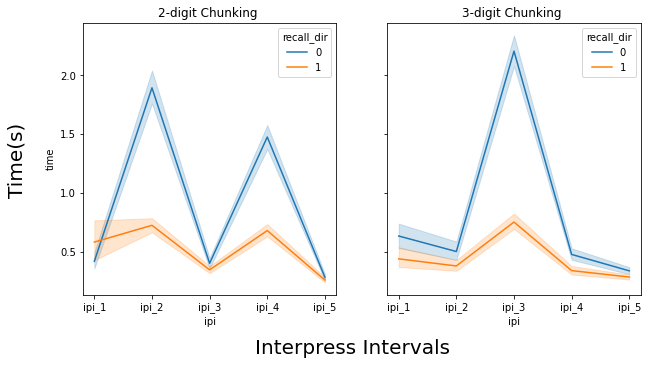

In [151]:
figure, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
sns.lineplot(ax=axes[0], data = Chunk2, hue = "recall_dir", x = "ipi", y = "time", color='r')
sns.lineplot(ax=axes[1], data = Chunk3, hue = "recall_dir", x = "ipi", y = "time", color='b')

figure.supylabel(r'Time(s)', x = 0.02, fontsize=20)
figure.supxlabel(r'Interpress Intervals', y= -0.05, fontsize=20)
    
axes[0].title.set_text(r'2-digit Chunking ')
axes[1].title.set_text(r'3-digit Chunking ')

plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\ipi_plot.pdf", dpi=300, bbox_inches = "tight")

In [152]:
C2_BW_i0 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_0'), ['time']]
C2_BW_i1 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_1'), ['time']]
C2_BW_i2 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_2'), ['time']]
C2_BW_i3 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_3'), ['time']]
C2_BW_i4 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_4'), ['time']]
C2_BW_i5 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_5'), ['time']]

C2_FW_i0 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_0'), ['time']]
C2_FW_i1 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_1'), ['time']]
C2_FW_i2 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_2'), ['time']]
C2_FW_i3 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_3'), ['time']]
C2_FW_i4 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_4'), ['time']]
C2_FW_i5 = a.loc[(a['chunk'] == 2) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_5'), ['time']]

C3_BW_i0 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_0'), ['time']]
C3_BW_i1 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_1'), ['time']]
C3_BW_i2 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_2'), ['time']]
C3_BW_i3 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_3'), ['time']]
C3_BW_i4 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_4'), ['time']]
C3_BW_i5 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 0) & (a['ipi'] == 'ipi_5'), ['time']]

C3_FW_i0 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_0'), ['time']]
C3_FW_i1 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_1'), ['time']]
C3_FW_i2 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_2'), ['time']]
C3_FW_i3 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_3'), ['time']]
C3_FW_i4 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_4'), ['time']]
C3_FW_i5 = a.loc[(a['chunk'] == 3) & (a['recall_dir'] == 1) & (a['ipi'] == 'ipi_5'), ['time']]

In [153]:
#IS CHUNKING HAPPENING: YES, Except at IPI0 forward 3-digit chunking
from statsmodels.stats.weightstats import ttest_ind as t

#BW 2- digit Chunking
print(t(C2_BW_i2, C2_BW_i1, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i2, C2_BW_i3, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i4, C2_BW_i3, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i4, C2_BW_i5, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

#FW 2- digit Chunking
print(t(C2_FW_i2, C2_FW_i1, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i2, C2_FW_i3, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i4, C2_FW_i3, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i4, C2_FW_i5, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

#BW 3- digit Chunking
print(t(C3_BW_i3, C3_BW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_BW_i3, C3_BW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

#FW 3- digit Chunking
print(t(C3_FW_i3, C3_FW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_FW_i3, C3_FW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

(array([18.22627725]), array([4.44052852e-62]), 778.0)
(array([19.51612032]), array([2.38263888e-69]), 778.0)
(array([18.90327695]), array([7.14685785e-66]), 778.0)
(array([22.12964465]), array([1.50243265e-84]), 778.0)
(array([1.45497679]), array([0.14607903]), 778.0)
(array([10.67949457]), array([6.14607562e-25]), 778.0)
(array([10.44378957]), array([5.52673619e-24]), 778.0)
(array([13.98404212]), array([8.35168188e-40]), 778.0)
(array([21.72785271]), array([3.51935608e-82]), 778.0)
(array([23.9390194]), array([2.50230071e-95]), 778.0)
(array([9.22188018]), array([2.68526105e-19]), 778.0)
(array([10.92974509]), array([5.74076659e-26]), 778.0)


In [154]:
#Convergence Points 2-digit; 
print(t(C2_BW_i1, C2_FW_i1, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i3, C2_FW_i3, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i5, C2_FW_i5, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

#Convergence Points 3-digit; 
print(t(C3_BW_i1, C3_FW_i1, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_BW_i2, C3_FW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_BW_i4, C3_FW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_BW_i5, C3_FW_i5, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

(array([-1.65201742]), array([0.0989345]), 778.0)
(array([2.05092222]), array([0.04060897]), 778.0)
(array([1.39851675]), array([0.16235643]), 778.0)
(array([2.82295589]), array([0.0048798]), 778.0)
(array([2.66638964]), array([0.00782628]), 778.0)
(array([4.41352567]), array([1.16059417e-05]), 778.0)
(array([2.83949653]), array([0.00463633]), 778.0)


In [155]:
#Peel-off Slope 2-digit
print(t(C2_BW_i0, C2_BW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_BW_i2, C2_BW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i0, C2_FW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C2_FW_i2, C2_FW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))


#Peel-off Slope 3-digit
print(t(C3_BW_i3, C3_BW_i0, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

(array([nan]), array([nan]), 388.0)
(array([4.65022593]), array([3.89496655e-06]), 778.0)
(array([nan]), array([nan]), 388.0)
(array([1.0593244]), array([0.28978083]), 778.0)
(array([nan]), array([nan]), 388.0)


c:\users\khash\appdata\local\programs\python\python39\lib\site-packages\statsmodels\stats\weightstats.py:135: RuntimeWarning: invalid value encountered in true_divide
  return self.sum / self.sum_weights
c:\users\khash\appdata\local\programs\python\python39\lib\site-packages\statsmodels\stats\weightstats.py:997: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(var_pooled * (1.0 / d1.nobs + 1.0 / d2.nobs))


In [156]:
#print(t(C2_BW_i2, C2_BW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
#print(t(C2_FW_i2, C2_FW_i4, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

print(t(C3_BW_i1, C3_BW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_FW_i1, C3_FW_i2, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_BW_i4, C3_BW_i5, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(C3_FW_i4, C3_FW_i5, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

(array([1.95949932]), array([0.05041104]), 778.0)
(array([1.25410869]), array([0.21017917]), 778.0)
(array([4.76064848]), array([2.3011565e-06]), 778.0)
(array([2.55246064]), array([0.01088643]), 778.0)


In [157]:
MT_df = pd.read_csv(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\data\behavioural\raw\a.csv")
MT_df = pd.DataFrame(MT_df)

Text(0, 0.5, 'Mean Movement Time(s)')

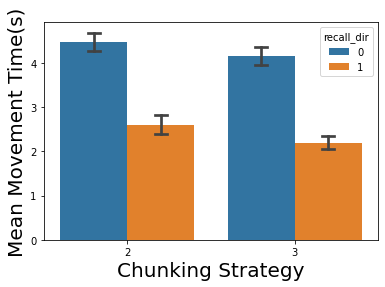

In [158]:
sns.barplot(x="chunk", y="MT", hue="recall_dir", capsize=0.07, data= MT_df)
plt.xlabel(r'Chunking Strategy', fontsize=20)
plt.ylabel(r'Mean Movement Time(s)', fontsize=20)
#plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\MT_plot.pdf", dpi=300, bbox_inches = "tight")

In [159]:
from statsmodels.stats.weightstats import ttest_ind as t

Chunk2_BW = MT_df.loc[(MT_df['chunk'] == 2) & (MT_df['recall_dir'] == 0) & (MT_df['MT'] != 0), ['MT']]
Chunk2_FW = MT_df.loc[(MT_df['chunk'] == 2) & (MT_df['recall_dir'] == 1) & (MT_df['MT'] != 0), ['MT']]
Chunk3_BW = MT_df.loc[(MT_df['chunk'] == 3) & (MT_df['recall_dir'] == 0) & (MT_df['MT'] != 0), ['MT']]
Chunk3_FW = MT_df.loc[(MT_df['chunk'] == 3) & (MT_df['recall_dir'] == 1) & (MT_df['MT'] != 0), ['MT']]

print(t(Chunk2_BW, Chunk2_FW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(Chunk3_BW, Chunk3_FW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(Chunk2_BW, Chunk3_BW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))
print(t(Chunk2_FW, Chunk3_FW, alternative='two-sided', usevar='pooled', weights=(None, None), value=0))

(array([12.02416447]), array([1.14870306e-30]), 778.0)
(array([14.8058293]), array([7.01368931e-44]), 778.0)
(array([2.10906825]), array([0.03525767]), 778.0)
(array([2.83996358]), array([0.00462962]), 778.0)


In [160]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM

MT_ANOVA = MT_df[['subject', 'chunk', 'recall_dir', 'MT']]

aovrm = AnovaRM(MT_df, 'MT', 'subject', within=['chunk', 'recall_dir'], aggregate_func='mean')
res = aovrm.fit()
print(res)

                     Anova
                 F Value  Num DF  Den DF Pr > F
-----------------------------------------------
chunk              8.8049 1.0000 14.0000 0.0102
recall_dir       109.5613 1.0000 14.0000 0.0000
chunk:recall_dir   0.1802 1.0000 14.0000 0.6777



Text(0, 0.5, 'Average Accuracy')

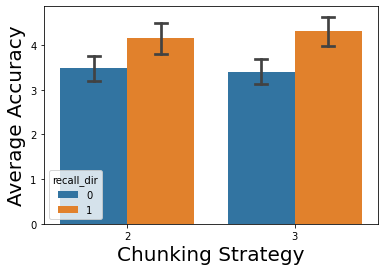

In [161]:
df_final['points'].replace(10, 6)
sns.barplot(x="chunk", y="points", hue="recall_dir", capsize=0.07, data= df_final)
plt.xlabel(r'Chunking Strategy', fontsize=20)
plt.ylabel(r'Average Accuracy', fontsize=20)
#plt.savefig(r"C:\Users\khash\OneDrive\Documents\GitHub\WM_chunking\analysis\MT_plot.pdf", dpi=300, bbox_inches = "tight"

In [162]:
Accuracy_ANOVA = df_final[['subject', 'chunk', 'recall_dir', 'points']]

aovrm = AnovaRM(MT_df, 'MT', 'subject', within=['chunk', 'recall_dir'], aggregate_func='mean')
res = aovrm.fit()
print(res)

                     Anova
                 F Value  Num DF  Den DF Pr > F
-----------------------------------------------
chunk              8.8049 1.0000 14.0000 0.0102
recall_dir       109.5613 1.0000 14.0000 0.0000
chunk:recall_dir   0.1802 1.0000 14.0000 0.6777



In [163]:
df_final['points'] = df_final['points'].replace(10, 6)
accuracy = ((df_final['points']/6)*100)
df_final['%_ACC']= accuracy

In [164]:
df = df_final.loc[(df_final['phase_type'] == 1) & (df_final['is_error'] == False)]
aa = calc_ipi(df)

In [165]:
Chunk2 = aa.loc[(aa['chunk'] == 2)  , ['subject', 'chunk', 'recall_dir', 'ipi','time']]
Chunk3 = aa.loc[(aa['chunk'] == 3)  , ['subject', 'chunk', 'recall_dir', 'ipi','time']]

C2_BW_i0 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_0'), ['time']]
C2_BW_i1 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_1'), ['time']]
C2_BW_i2 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_2'), ['time']]
C2_BW_i3 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_3'), ['time']]
C2_BW_i4 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_4'), ['time']]
C2_BW_i5 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_5'), ['time']]

C2_FW_i0 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_0'), ['time']]
C2_FW_i1 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_1'), ['time']]
C2_FW_i2 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_2'), ['time']]
C2_FW_i3 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_3'), ['time']]
C2_FW_i4 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_4'), ['time']]
C2_FW_i5 = aa.loc[(aa['chunk'] == 2) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_5'), ['time']]

C3_BW_i0 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_0'), ['time']]
C3_BW_i1 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_1'), ['time']]
C3_BW_i2 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_2'), ['time']]
C3_BW_i3 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_3'), ['time']]
C3_BW_i4 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_4'), ['time']]
C3_BW_i5 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 0) & (aa['ipi'] == 'ipi_5'), ['time']]

C3_FW_i0 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_0'), ['time']]
C3_FW_i1 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_1'), ['time']]
C3_FW_i2 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_2'), ['time']]
C3_FW_i3 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_3'), ['time']]
C3_FW_i4 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_4'), ['time']]
C3_FW_i5 = aa.loc[(aa['chunk'] == 3) & (aa['recall_dir'] == 1) & (aa['ipi'] == 'ipi_5'), ['time']]


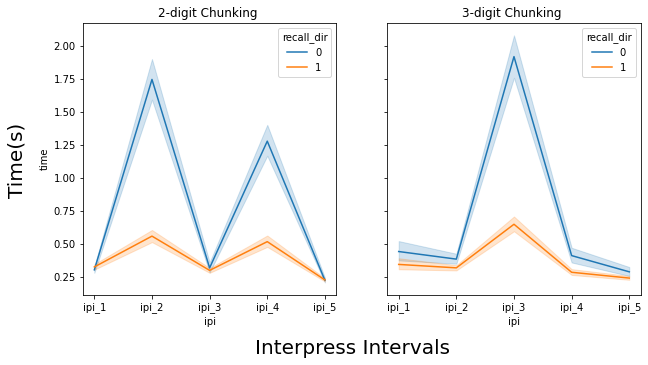

In [166]:
figure, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
sns.lineplot(ax=axes[0], data = Chunk2, hue = "recall_dir", x = "ipi", y = "time", color='r')
sns.lineplot(ax=axes[1], data = Chunk3, hue = "recall_dir", x = "ipi", y = "time", color='b')

figure.supylabel(r'Time(s)', x = 0.02, fontsize=20)
figure.supxlabel(r'Interpress Intervals', y= -0.05, fontsize=20)
    
axes[0].title.set_text(r'2-digit Chunking ')
axes[1].title.set_text(r'3-digit Chunking ')

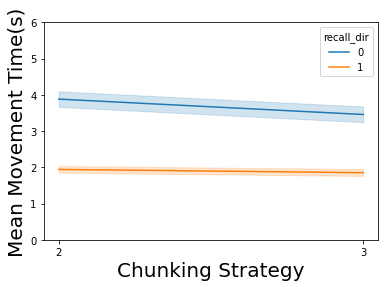

In [167]:
fig, ax = plt.subplots()
sns.lineplot(x="chunk", y="MT", hue="recall_dir", data= df)
plt.xlabel(r'Chunking Strategy', fontsize=20)
plt.ylabel(r'Mean Movement Time(s)', fontsize=20)
plt.ylim(0, 6)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
plt.locator_params(axis='x', nbins=1)

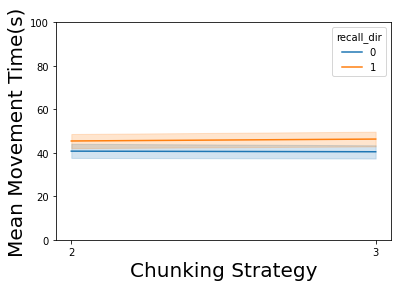

In [168]:
fig, ax = plt.subplots()
sns.lineplot(x="chunk", y="%_ACC", hue="recall_dir", data= df_final)
plt.xlabel(r'Chunking Strategy', fontsize=20)
plt.ylabel(r'Mean Movement Time(s)', fontsize=20)
plt.ylim(0, 100)
plt.xlim(2,3)
plt.autoscale(enable=True, axis='x', tight=False)
plt.locator_params(axis='x', nbins=1)